In [1]:
import pickle
import sys
import os
import json
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import trimesh

sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID
%matplotlib widget
skipping_ani_ids = ['751004','751769']
skipping_ani_ids = []

In [2]:
# Load the CCF summary CSV file
ccf_file_path = '/root/capsule/code/data_management/combined_ephys_session_ccf_summary.csv'
ccf_file_path = '/root/capsule/scratch/combined/combine_unit_tbl/combined_ephys_session_ccf_summary.pkl'
if '.csv' in ccf_file_path:
    ccf_df = pd.read_csv(ccf_file_path)
elif '.pkl' in ccf_file_path:
    with open(ccf_file_path, 'rb') as f:
        ccf_df = pickle.load(f)
        
# load the combined pickle file
combined_pickle_path = '/root/capsule/scratch/combined/combine_unit_tbl/combined_unit_tbl.pkl'
with open(combined_pickle_path, 'rb') as f:
    combined_unit_tbl = pickle.load(f)

In [3]:
for ind, row in ccf_df.iterrows():
    session = row['session']
    aniID, date_obj, raw_id = parseSessionID(session)
    if aniID not in skipping_ani_ids:
        # check if element is saved as a string
        units = ast.literal_eval(row['units']) if isinstance(row['units'], str) else row['units']
        ccfs = ast.literal_eval(row['unit_ccf_pts']) if isinstance(row['unit_ccf_pts'], str) else row['unit_ccf_pts']
        if ccfs is not None:
            for unit, ccf in zip(units, ccfs):
                if len(combined_unit_tbl[(combined_unit_tbl['unit'] == unit) & (combined_unit_tbl['session'] == session)]) > 0:
                    combined_unit_tbl.loc[(combined_unit_tbl['unit'] == unit) & (combined_unit_tbl['session'] == session), 'x_ccf'] = ccf[0]
                    combined_unit_tbl.loc[(combined_unit_tbl['unit'] == unit) & (combined_unit_tbl['session'] == session), 'y_ccf'] = ccf[1]
                    combined_unit_tbl.loc[(combined_unit_tbl['unit'] == unit) & (combined_unit_tbl['session'] == session), 'z_ccf'] = ccf[2]
                else:
                    print(f"Unit {unit} in session {session} not found in combined_unit_tbl. Skipping update.")

In [4]:
# update the existing pickle file with the new CCF coordinates
with open(combined_pickle_path, 'wb') as f:
    pickle.dump(combined_unit_tbl, f)

Loading mesh: 20250418_transformed_remesh_10_ccf25 from /root/capsule/scratch/combined/20250418_transformed_remesh_10_ccf25.obj


ValueError: string is not a file: `/root/capsule/scratch/combined/20250418_transformed_remesh_10_ccf25.obj`

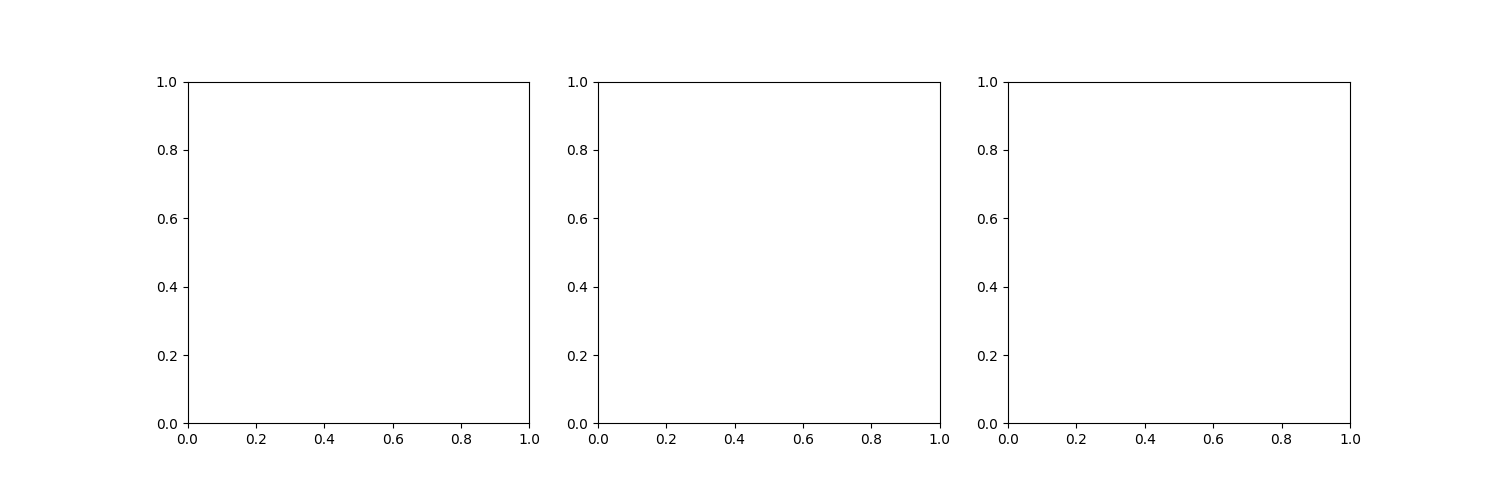

In [5]:
ml, ap, dv = 2, 0, 1
ccf_res = 25
bregma_points = np.array([216, 18, 228])  # Example bregma points in ccf space
voxel_size = 25
dot_size = 5

# --- Mesh Paths ---
mesh_files = {
    # "LC_newMesh_90_left_ccf25": f"{LC_masks_folder}/LC_newMesh_90_left_ccf25.obj",    
    "20250418_transformed_remesh_10_ccf25": "/root/capsule/scratch/combined/20250418_transformed_remesh_10_ccf25.obj",
 
}
# mesh_files.update({row["obj_filename"]: row["obj_file_path"] for row in data_list})
 
# --- Plot Setup ---
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax_titles = ['Sagittal Plane', 'Horizontal Plane', 'Coronal Plane']
plane_axes = [(0, 1), (0, 2), (2, 1)]
 
for a in ax:
    a.set_aspect('equal')
 
# --- Plot Meshes ---
for mesh_name, mesh_path in mesh_files.items():
    print(f"Loading mesh: {mesh_name} from {mesh_path}")
    mesh = trimesh.load(mesh_path)
 
    if mesh.is_empty:
        print(f"⚠️ Skipped: '{mesh_path}' is empty.")
        continue
 
    mesh_vertices = np.array(mesh.vertices)
 
 
    if mesh_name == "LC_newMesh_90_left_ccf25":
        color = 'gray'
    elif mesh_name == "20250418_transformed_remesh_10_ccf25":
        color = 'green'
   
    mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices, bregma_points, voxel_size)
    mesh_vertices_mm[:, 2] = -np.abs(mesh_vertices_mm[:, 2])  # Mirror ML to left
    mesh_alpha_default = 0.05
    alpha = mesh_alpha_default if 'LC' in mesh_name else 0.05
 
    for i, (x, y) in enumerate(plane_axes):
        ax[i].scatter(mesh_vertices_mm[:, x], mesh_vertices_mm[:, y],
                      color=color, s=dot_size, alpha=alpha, label=mesh_name)
        ax[i].set_aspect('equal', adjustable='box')
        if y == 1:
            ax[i].invert_yaxis()
        if x == 0:
            ax[i].invert_xaxis()

In [ ]:
for i, row in ccf_df.iterrows():
    ccfs = row['unit_ccf_pts']
    if ccfs is not None:
        print(row['session_id'])
        ccfs = np.array(ccfs)
        ccfs = ccf_pts_convert_to_mm(ccfs, bregma_points, voxel_size)
        if np.mean(ccfs[:, ml]) > 0:
            ccfs[:, ml] = ccfs[:, ml] * -1  # flip ML-axis
        print(ccfs.shape)
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(141, projection='3d')
        ax.scatter(ccfs[:, ml], ccfs[:, ap], ccfs[:, dv], c='r', marker='o')
        ax.scatter(mesh_vertices_mm[:, ml], mesh_vertices_mm[:, ap], mesh_vertices_mm[:, dv],
                    color=color, s=1, alpha=0.1, edgecolors='none')
        ax.set_aspect('equal', adjustable='box')

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('ml')
        ax.set_ylabel('ap')
        ax.set_zlabel('dv')
        ax.invert_zaxis()
        ax.invert_yaxis()
        ax.set_title(row['session_id'])

        for i, (x, y) in enumerate(plane_axes):
            ax = fig.add_subplot(1, 4, i + 1)
            ax.scatter(mesh_vertices_mm[:, x], mesh_vertices_mm[:, y],
                        color=color, s=1, alpha=0.1, label=mesh_name)
            ax.set_aspect('equal', adjustable='box')
            ax.scatter(ccfs[:, x], ccfs[:, y], c='r', marker='o', s=5, alpha=0.7)
            if y == 1:
                ax.invert_yaxis()
            if x == 0:
                ax.invert_xaxis()

716325_2024-05-31_10-31-14


NameError: name 'ccf_pts_convert_to_mm' is not defined